# Importing Data

In [184]:
import pandas as pd
import numpy as np
import keras
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score;

In [2]:
digits_train = pd.read_csv("train.csv")
digits_test = pd.read_csv("test.csv")

In [3]:
digits_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Explorarary Data Analysis

## Structure of Data

In [74]:
digits_train.shape

(42000, 785)

Training dataset:
-  28x28 image in 784 columns and 1 label
- 42000 images

In [7]:
digits_test.shape

(28000, 784)

Test dataset:
- 28x28 image in 784 columns
- 28000 images

In [81]:
X_test = digits_test

In [110]:
X_train, y_train = digits_train.iloc[:,1:], digits_train["label"]

## Null values

In [111]:
digits_train.isna().sum().describe()

count    785.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

There are no null values

## Visualize the images

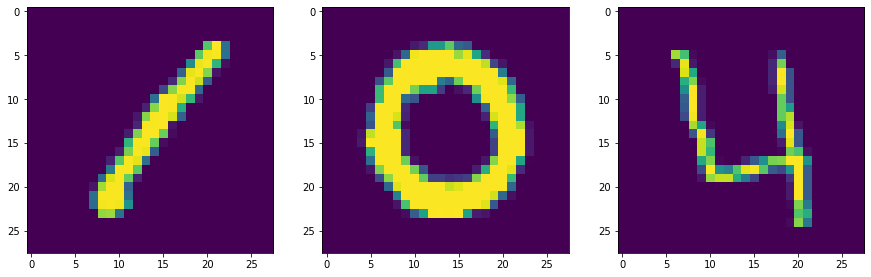

In [112]:
#Let's check how few images look like
fig, ax = plt.subplots(1,3, figsize = (15,5))
ax[0].imshow(np.array(X_train.iloc[0]).reshape(28,28))
ax[1].imshow(np.array(X_train.iloc[1]).reshape(28,28))
ax[2].imshow(np.array(X_train.iloc[3]).reshape(28,28));

## Distribution of Image labels

In [113]:
y_counts = y_train.value_counts(sort = True, normalize = True)
digits_train.groupby("label").agg({"label":"count"})

,label
label,
0,4132
1,4684
2,4177
3,4351
4,4072
5,3795
6,4137
7,4401
8,4063


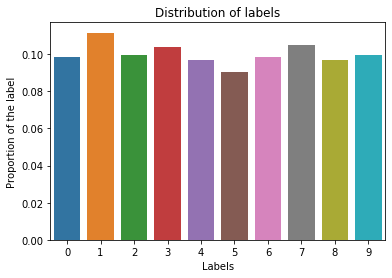

In [114]:
plt.figure(figsize = (6,4))
ax = sns.barplot(x=y_counts.index, y = y_counts.values)
ax.set_title("Distribution of labels")
ax.set_ylabel("Proportion of the label")
ax.set_xlabel("Labels");

We observe the labels are fairly evenly distributed

Divide the data into train and validation sets before modeling

# Data Engineering / Wrangling

## Normalizing
Neural networks converge faster for normalized data. The data has max 255 represeting the brightness of the image

In [115]:
X_train = X_train / 255
X_test = X_test / 255

## Converting labels to categorical outputs

In [116]:
y_train = to_categorical(y_train, num_classes = 10)

## Splitting the training data
- training set
- test set

We do not have labels for the test set provided on Kaggle. Hence, we test on them later

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)

## Reshaping data for use in CNN
- Length x width = 28X28
- Channel = 1

In [180]:
X_train_r, X_test_r = X_train.values.reshape(-1,28,28,1), X_test.values.reshape(-1,28,28,1)

# Modeling

In [185]:
Summary_table = pd.DataFrame(columns = ["model", "Test accuracy"])

## Logistic Regression
Baseline model for comparison 

In [188]:
lr = LogisticRegression(max_iter = 1000)

In [189]:
lr.fit(X_train, np.argmax(y_train, axis = 1))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [191]:
test_accuracy = lr.score(X_test, np.argmax(y_test, axis = 1))

In [194]:
Summary_table  = Summary_table.append({"model": "Logistic Regression", "Test accuracy": test_accuracy }, ignore_index = True)

In [195]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.917708


## Shallow fully connected Neural Network
- Hidden layer1: 5 nodes, activation function: relu
- Optimizer: Adam
- Early stoppng: 10, stops further epochs iteration if the validation accuracy does not improve for 10 iterations

In [196]:
model_s = Sequential()
model_s.add(Dense(5, input_shape = (784,), activation = "relu"))
model_s.add(Dense(10, activation = "softmax"))
model_s.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [197]:
model_s.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 5)                 3925      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                60        
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


There are:
- Layer1: Weights =  784*5, Bias(each node's) = 5. Total = 3925
- Layer2 (output): Weights = 5*10 = 50, Bias (each node's) = 10. Total 60

Toatal parameters = 3985

In [200]:
early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10)

In [201]:
history = model_s.fit(X_train, y_train, epochs = 100, validation_split = 0.2, callbacks = [early_stopping])

Train on 21504 samples, validate on 5376 samples
Epoch 1/100
21504/21504 [==============================] - 1s 40us/step - loss: 0.3151 - accuracy: 0.9104 - val_loss: 0.3975 - val_accuracy: 0.8884
Epoch 2/100
21504/21504 [==============================] - 1s 41us/step - loss: 0.3146 - accuracy: 0.9102 - val_loss: 0.3983 - val_accuracy: 0.8878
Epoch 3/100
21504/21504 [==============================] - 1s 42us/step - loss: 0.3142 - accuracy: 0.9088 - val_loss: 0.3968 - val_accuracy: 0.8895
Epoch 4/100
21504/21504 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.9108 ETA: 0s - l - 1s 42us/step - loss: 0.3121 - accuracy: 0.9107 - val_loss: 0.3976 - val_accuracy: 0.8878
Epoch 5/100
21504/21504 [==============================] - 1s 41us/step - loss: 0.3112 - accuracy: 0.9095 - val_loss: 0.3978 - val_accuracy: 0.8906
Epoch 6/100
21504/21504 [==============================] - 1s 44us/step - loss: 0.3113 - accuracy: 0.9102 - val_loss: 0.4004 - val_accuracy: 0.8897
Epoch 7

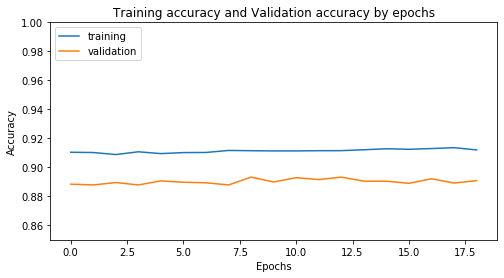

In [202]:
fig = plt.figure(figsize = (8,4))
ax1= plt.plot(history.history["accuracy"], label = "training")
ax2 = plt.plot(history.history["val_accuracy"], label = "validation")
plt.legend(loc="upper left")
plt.xlabel("Epochs")
plt.ylim(0.85,1)
plt.ylabel("Accuracy")
plt.title("Training accuracy and Validation accuracy by epochs");

In [207]:
test_accuracy = model_s.evaluate(X_test, y_test)[1]

6720/6720 [==============================] - 0s 26us/step


In [208]:
Summary_table  = Summary_table.append({"model": "Shallow NN", "Test accuracy": test_accuracy }, ignore_index = True)

In [209]:
Summary_table

,model,Test accuracy
0,Logistic Regression,0.917708
1,Shallow NN,0.884673
